In [188]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler,FunctionTransformer,OneHotEncoder # For encoding categorical variables it doesnt matter if they are ordinal or not
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
import time



In [189]:
# Load dataset
data = pd.read_csv('heart.csv')
#print(data.head())
print(data.info())
#print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


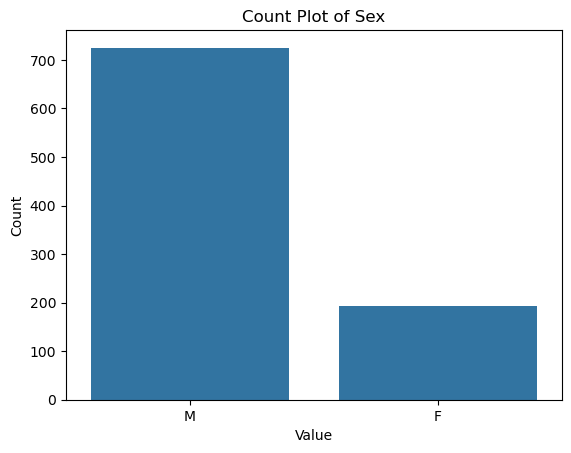

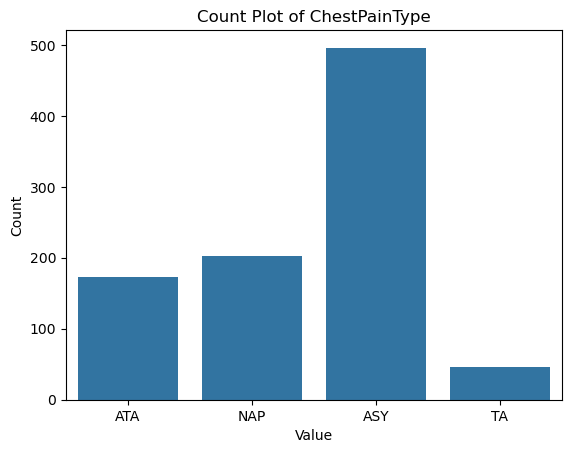

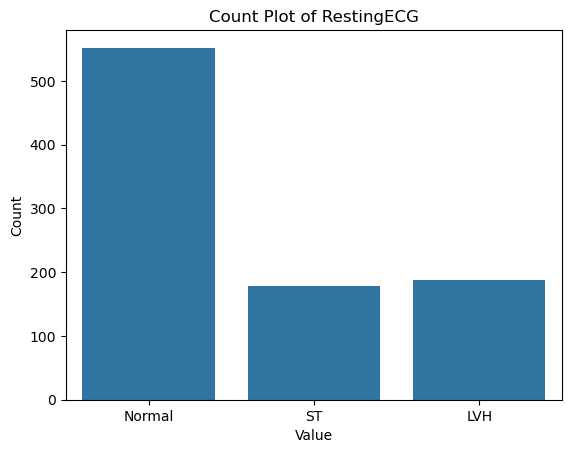

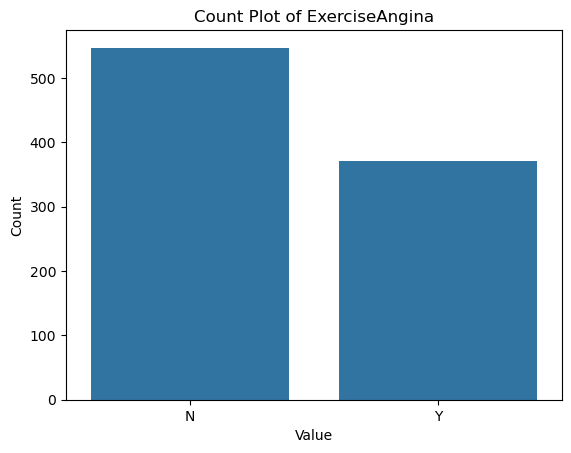

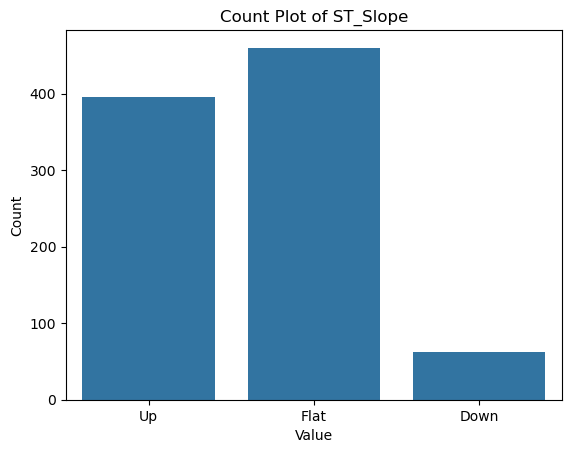

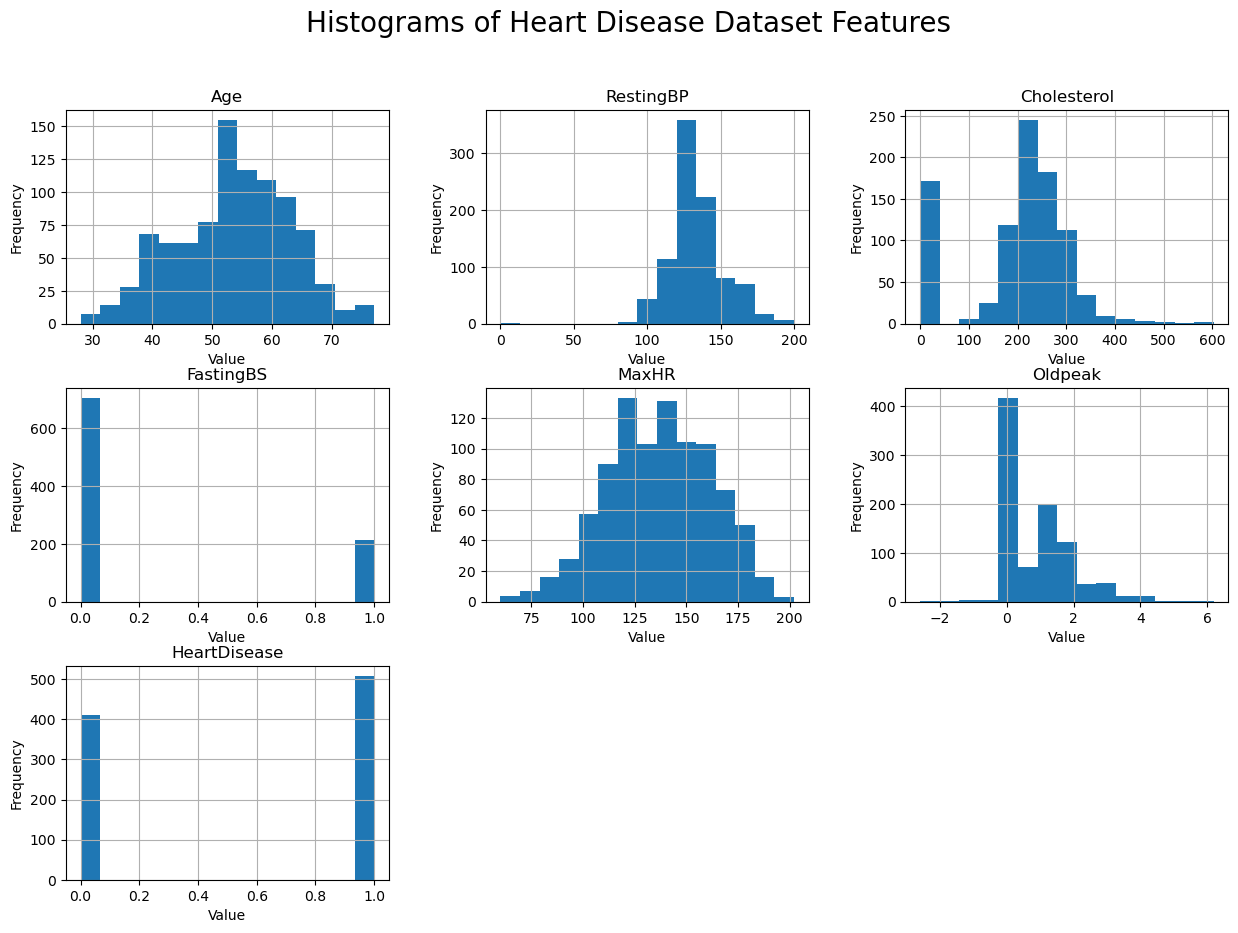

In [190]:
# EDA

# Categorial features count plots
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

for feature in categorical_features:
    sns.countplot(x=feature, data=data)
    plt.title(f'Count Plot of {feature}')
    plt.xlabel("Value")
    plt.ylabel('Count')
    plt.show()


# Histograms of numerical features
axes = data.hist(bins=15, figsize=(15, 10))
for ax in axes.flatten():
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

plt.suptitle("Histograms of Heart Disease Dataset Features", fontsize=20)
plt.show()

In [191]:
# Distingushing numerical and categorical features and train test split

categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocessing pipelines for both numerical and categorical data

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])


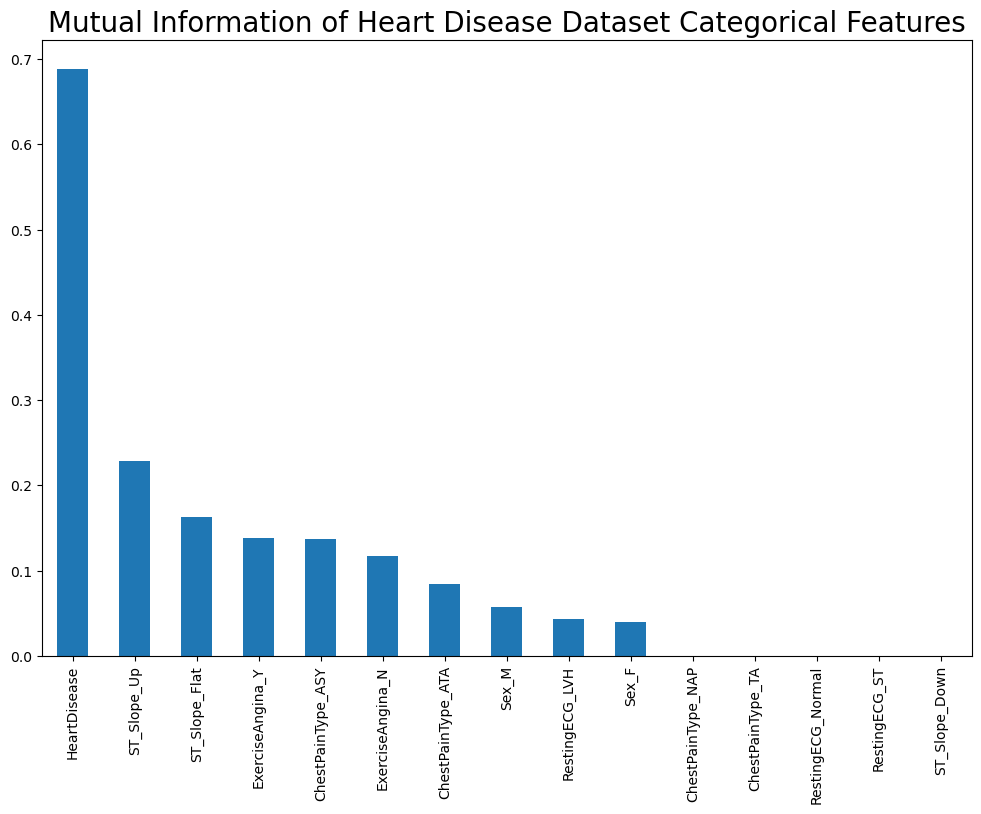

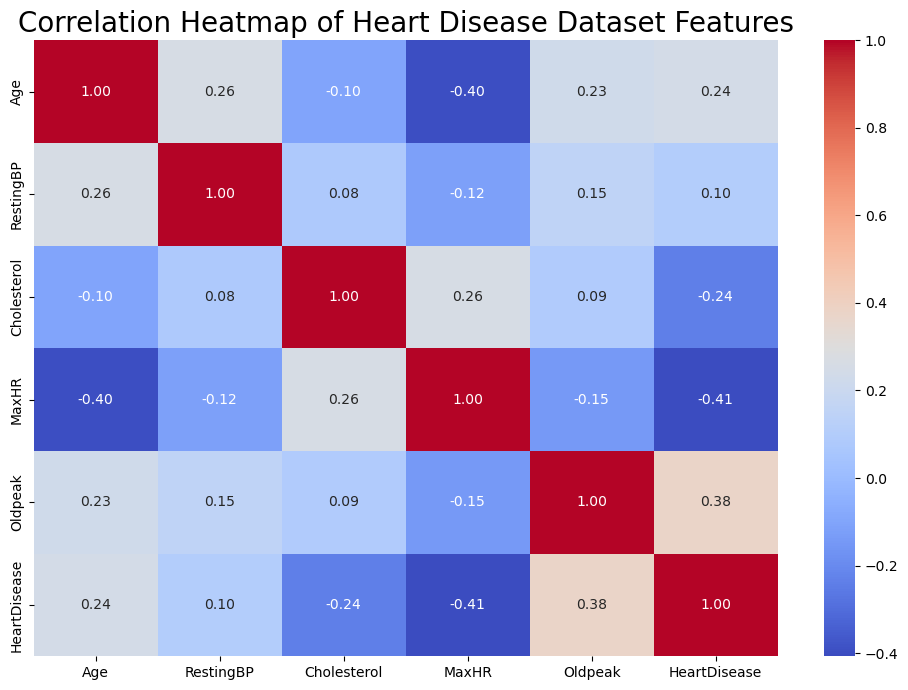

In [192]:
# Preproces the data for correlation heatmap
eda_train = X_train.copy()
eda_train = preprocessor.fit_transform(eda_train)

# Get feature names after one-hot encoding
ohe_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, ohe_feature_names])

# Convert to DataFrame
numerical_eda_train_df = pd.DataFrame(eda_train[:, :len(numerical_features)], columns=numerical_features, index=X_train.index)
categorical_eda_train_df = pd.DataFrame(eda_train[:, len(categorical_features):], columns=ohe_feature_names, index=X_train.index)

# Add target column
categorical_eda_train_df['HeartDisease'] = y_train.values

# Mutual information for categorical features
mutual_info = mutual_info_classif(categorical_eda_train_df, y_train, random_state=42)
mutual_info_series = pd.Series(mutual_info, index=categorical_eda_train_df.columns)
mutual_info_series = mutual_info_series.sort_values(ascending=False)

# Add target column
numerical_eda_train_df['HeartDisease'] = y_train.values

# Mutual information for categorical features
plt.figure(figsize=(12, 8))
mutual_info_series.plot(kind='bar')
plt.title("Mutual Information of Heart Disease Dataset Categorical Features", fontsize=20)
plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
correlation_matrix = numerical_eda_train_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Heart Disease Dataset Features", fontsize=20)
plt.show()


In [193]:
# We also need to see feature importance after training the model
# Create the preprocessing and training pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_distributions = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter tuning with RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=skf,
    verbose=0,
    n_jobs=-1,
    random_state=42
)

In [194]:
# Fit the model
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
print(f"RandomizedSearchCV took {end_time - start_time:.2f} seconds to complete.")
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate the model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
print(f"ROC AUC Score: {roc_auc:.4f}")

RandomizedSearchCV took 5.08 seconds to complete.
Best Hyperparameters: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': None, 'classifier__bootstrap': False}
Accuracy: 0.9022
Confusion Matrix:
[[71 11]
 [ 7 95]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89        82
           1       0.90      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

ROC AUC Score: 0.9254


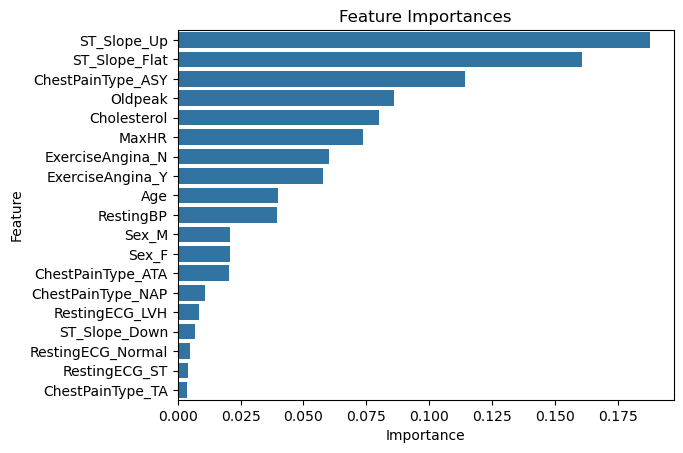

In [195]:
# Plot Feature importance
feature_importances = best_model.named_steps['classifier'].feature_importances_
feature_names = all_feature_names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

In [196]:
# Feature Engineering based on feature importance
data = data.copy()

X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

drop_columns = ['ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Down','ChestPainType_NAP']


numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
)

def drop_unimportant_features(X):
    X_df = pd.DataFrame(X, columns=all_feature_names)
    X_dropped = X_df.drop(columns=drop_columns, errors='ignore')
    return X_dropped

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_dropper', FunctionTransformer(drop_unimportant_features)),
    ('classifier', RandomForestClassifier(random_state=42))
    
])




In [197]:
# Hyperparameter tuning with RandomizedSearchCV (after feature engineering) 
random_search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    cv=skf,
    verbose=0,
    n_jobs=-1,
    random_state=42
)

# Fit the model
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()  
print(f"RandomizedSearchCV took {end_time - start_time:.2f} seconds to complete.")  
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate the model (after feature engineering)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]) 

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
print(f"ROC AUC Score: {roc_auc:.4f}")



RandomizedSearchCV took 4.93 seconds to complete.
Best Hyperparameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None, 'classifier__bootstrap': True}
Accuracy: 0.9130
Confusion Matrix:
[[72 10]
 [ 6 96]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        82
           1       0.91      0.94      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184

ROC AUC Score: 0.9313


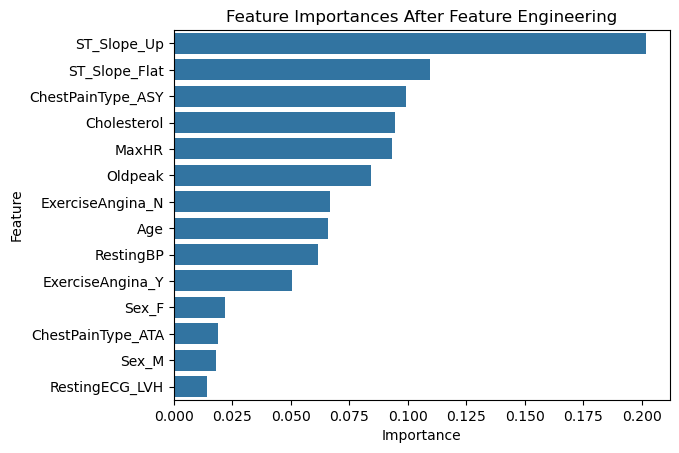

In [199]:
# Feature importance (after feature engineering)

feature_importances = best_model.named_steps['classifier'].feature_importances_
feature_names = [f for f in all_feature_names if f not in drop_columns]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot Feature importance
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances After Feature Engineering')
plt.show()
 
